this notebook is the stacking of my highest score's notebook (72040) The main improvement is adding this feature: oof difference between MSE and MAE

and this public notebook[https://www.kaggle.com/code/allegich/price-cars-prediction-eda-blending/notebook#About-this-competition](http://), Thanks a lot! @Allegich

I would greatly appreciate it if you would consider upvote.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool

from sklearn.svm import SVR
from xgboost import XGBRegressor



import random

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import optuna

USE_OPTUNA = False

In [2]:
%%time

sample_sub = pd.read_csv("C:/Users/david/OneDrive/Desktop/hackathon-qualification/Data/sample_submission.csv")
train = pd.read_csv("C:/Users/david/OneDrive/Desktop/hackathon-qualification/Data/train.csv")
test = pd.read_csv("C:/Users/david/OneDrive/Desktop/hackathon-qualification/Data/test.csv")


train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)


CPU times: total: 562 ms
Wall time: 577 ms


In [3]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [6]:
train.describe()

,model_year,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


In [7]:
cat_cols = [col for col in test.columns if test[col].dtype == 'object']
num_col = [col for col in test.columns if test[col].dtype == 'int64']

In [8]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype == 'int64']

In [9]:
for col in cat_cols:
    print(col, " : ", train[col].isnull().sum())

brand  :  0
model  :  0
fuel_type  :  5083
engine  :  0
transmission  :  0
ext_col  :  0
int_col  :  0
accident  :  2452
clean_title  :  21419


In [10]:
for col in cat_cols :
    print(col, " : ", test[col].isnull().sum())

brand  :  0
model  :  0
fuel_type  :  3383
engine  :  0
transmission  :  0
ext_col  :  0
int_col  :  0
accident  :  1632
clean_title  :  14239


In [11]:
print(train['fuel_type'].unique())
print(test['fuel_type'].unique())

['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
['Gasoline' 'Hybrid' 'Diesel' 'E85 Flex Fuel' nan 'Plug-In Hybrid' '–'
 'not supported']


### Missing data in num col

In [12]:
for col in num_cols:
    print(col, " : ", train[col].isnull().sum())

model_year  :  0
milage  :  0
price  :  0


In [13]:
for col in num_col:
    print(col, " : ", test[col].isnull().sum())

model_year  :  0
milage  :  0


In [14]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype == 'int64']

In [15]:
cat_cols

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

In [16]:
num_cols

['model_year', 'milage', 'price']

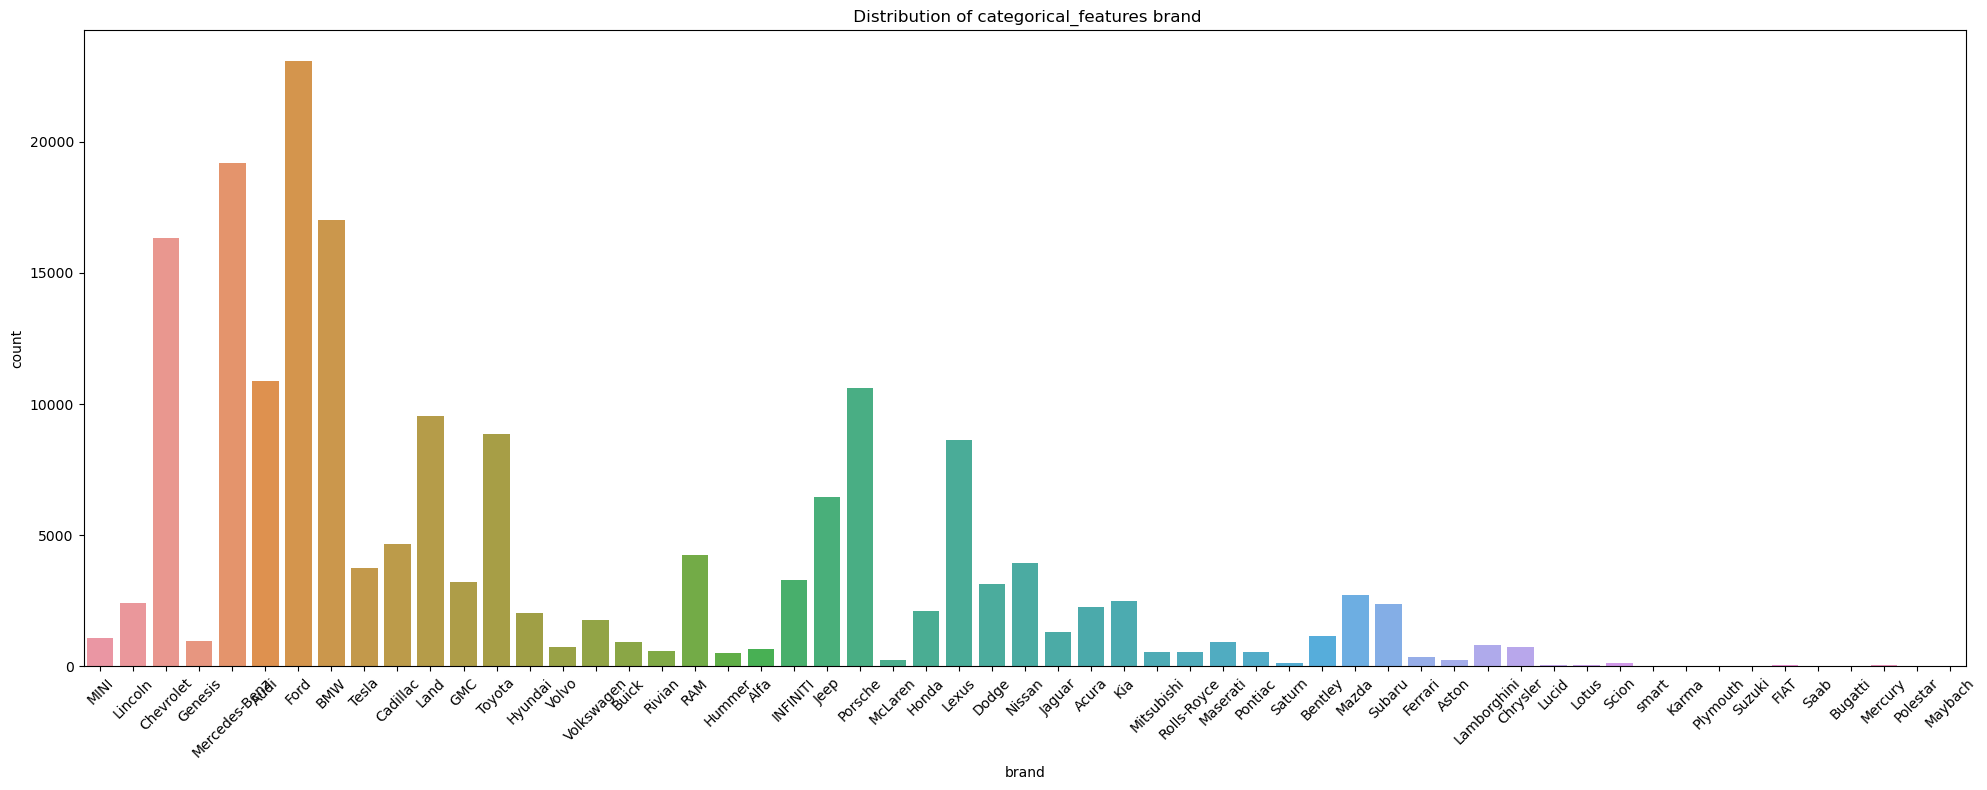

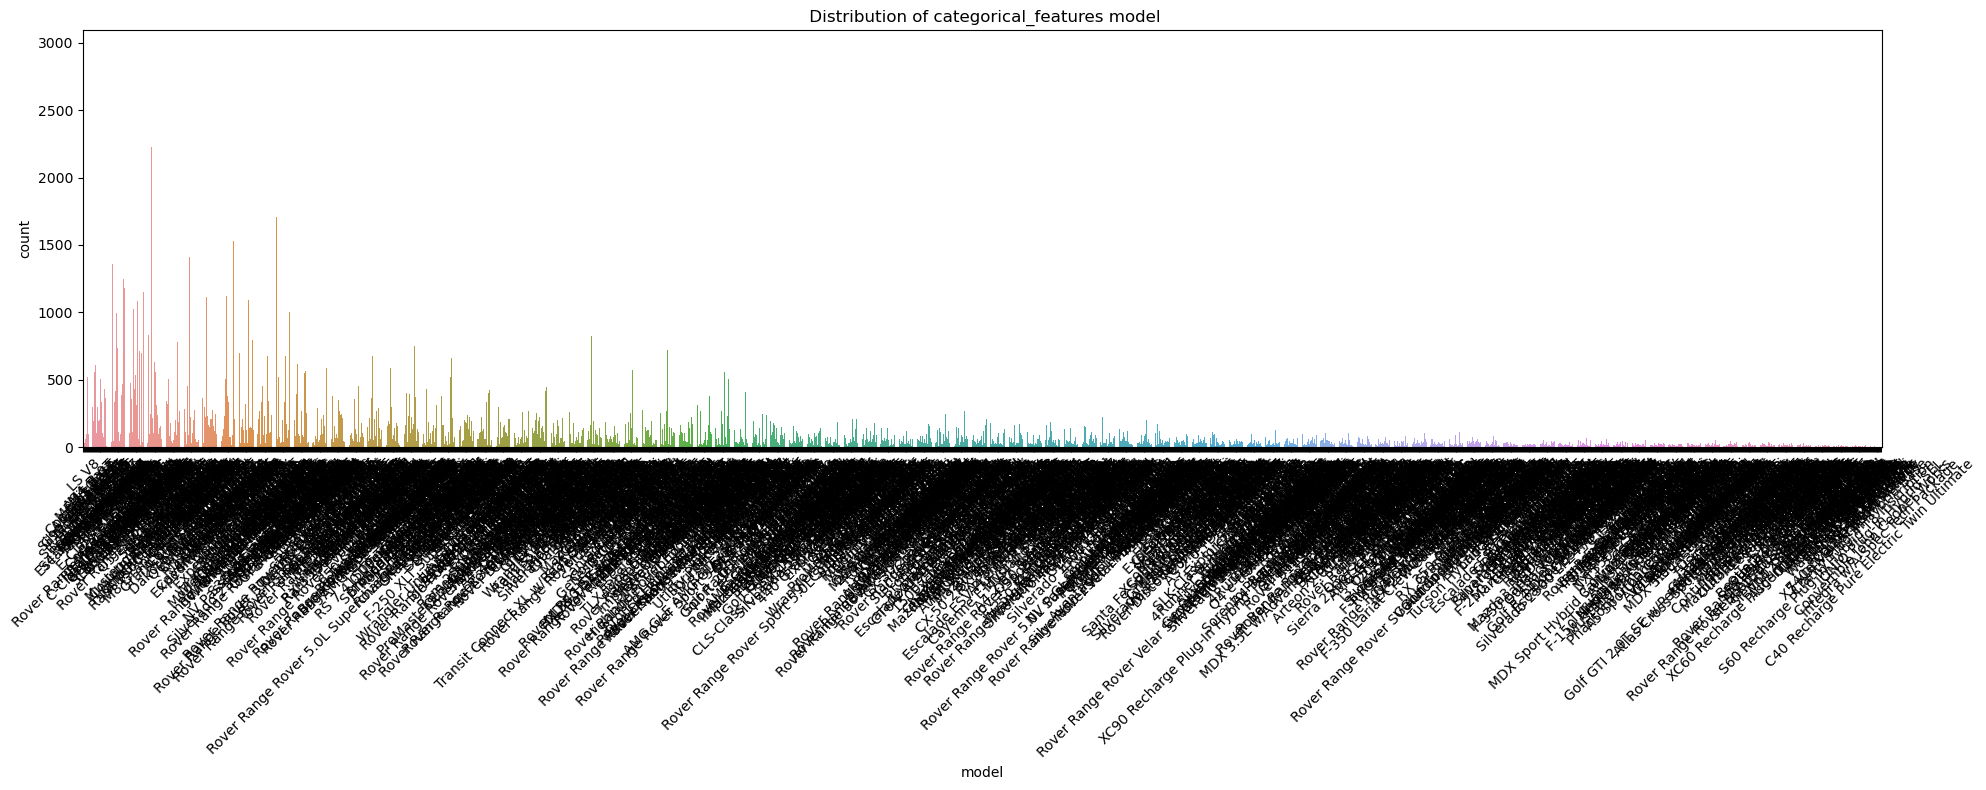

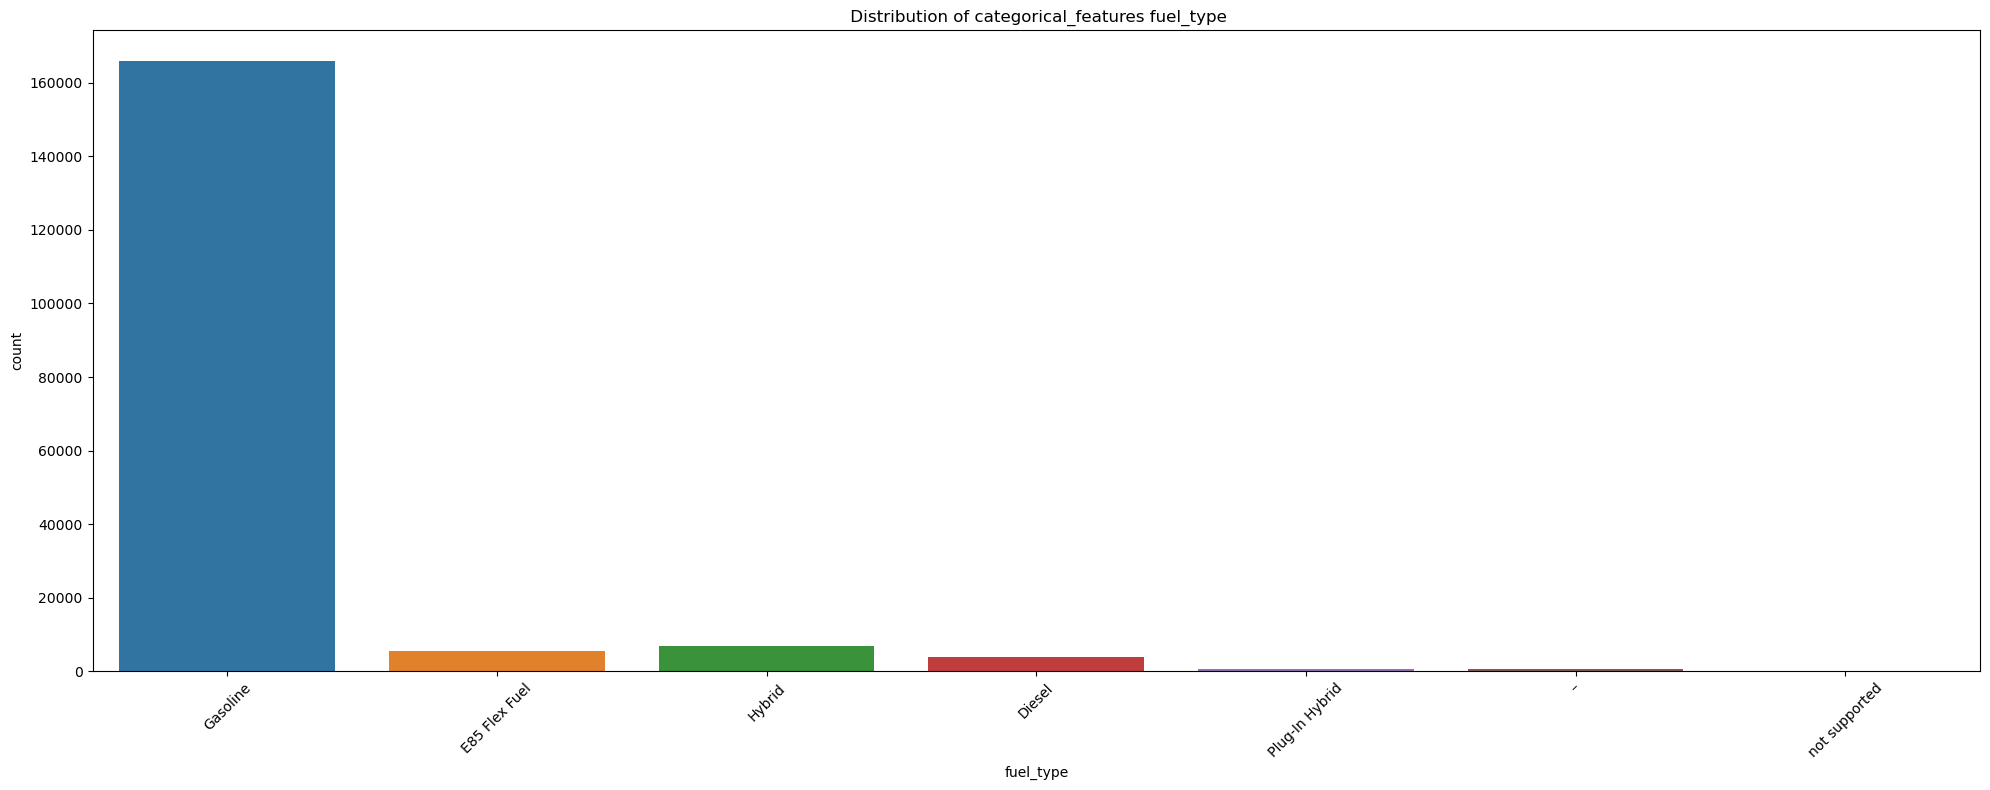

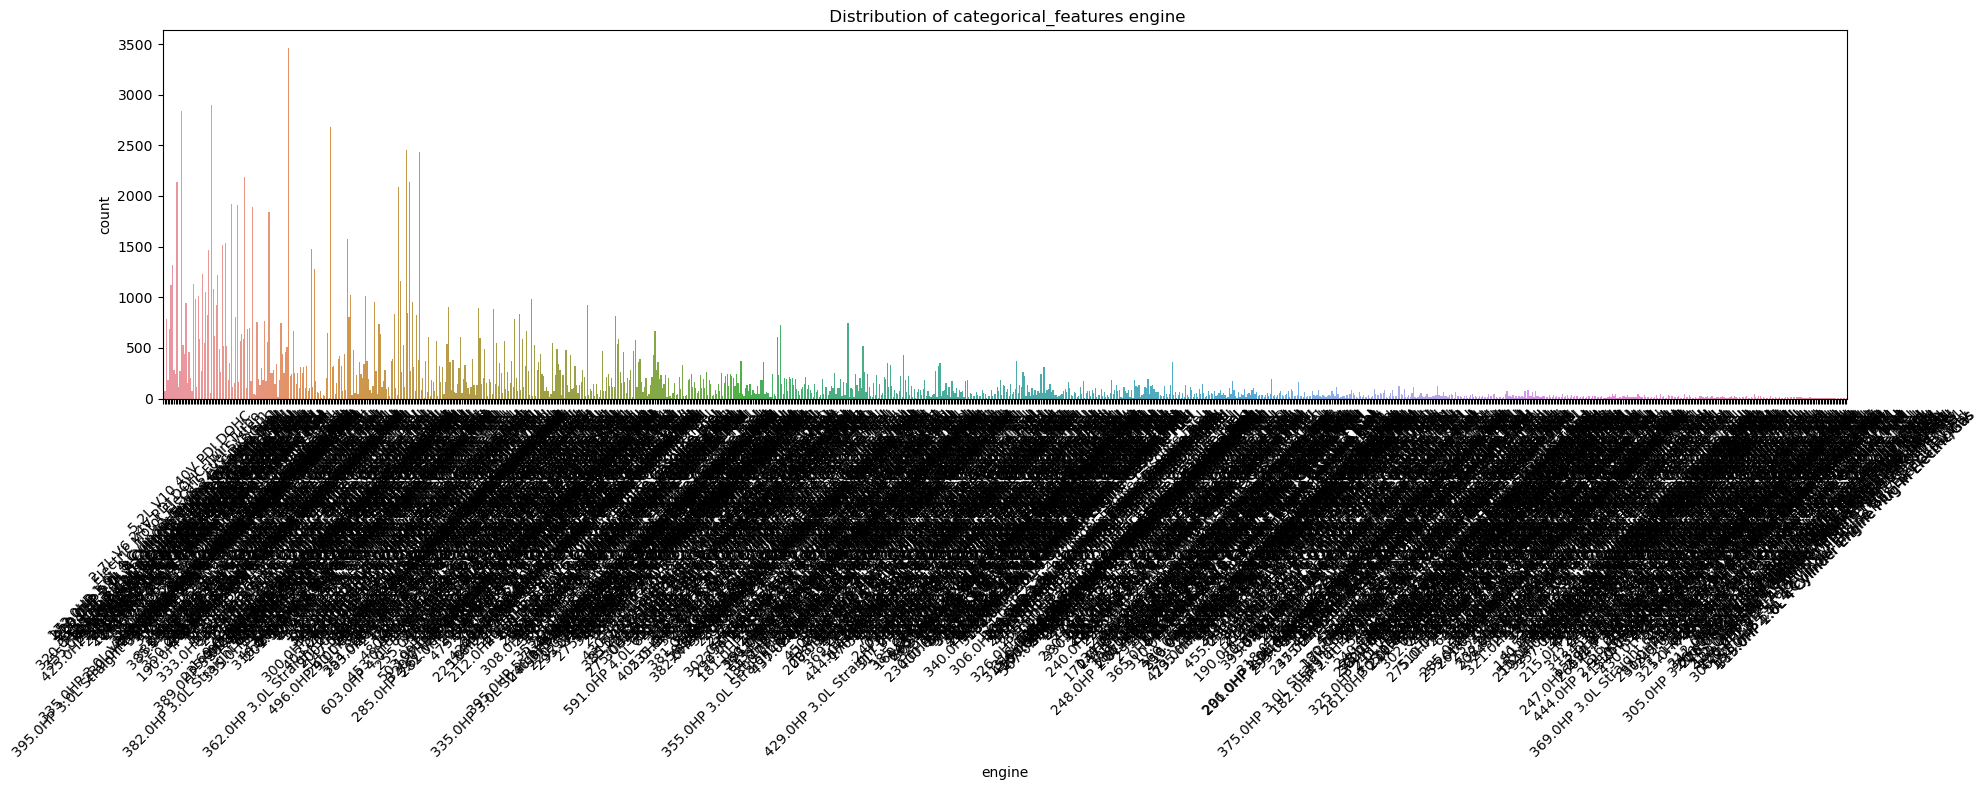

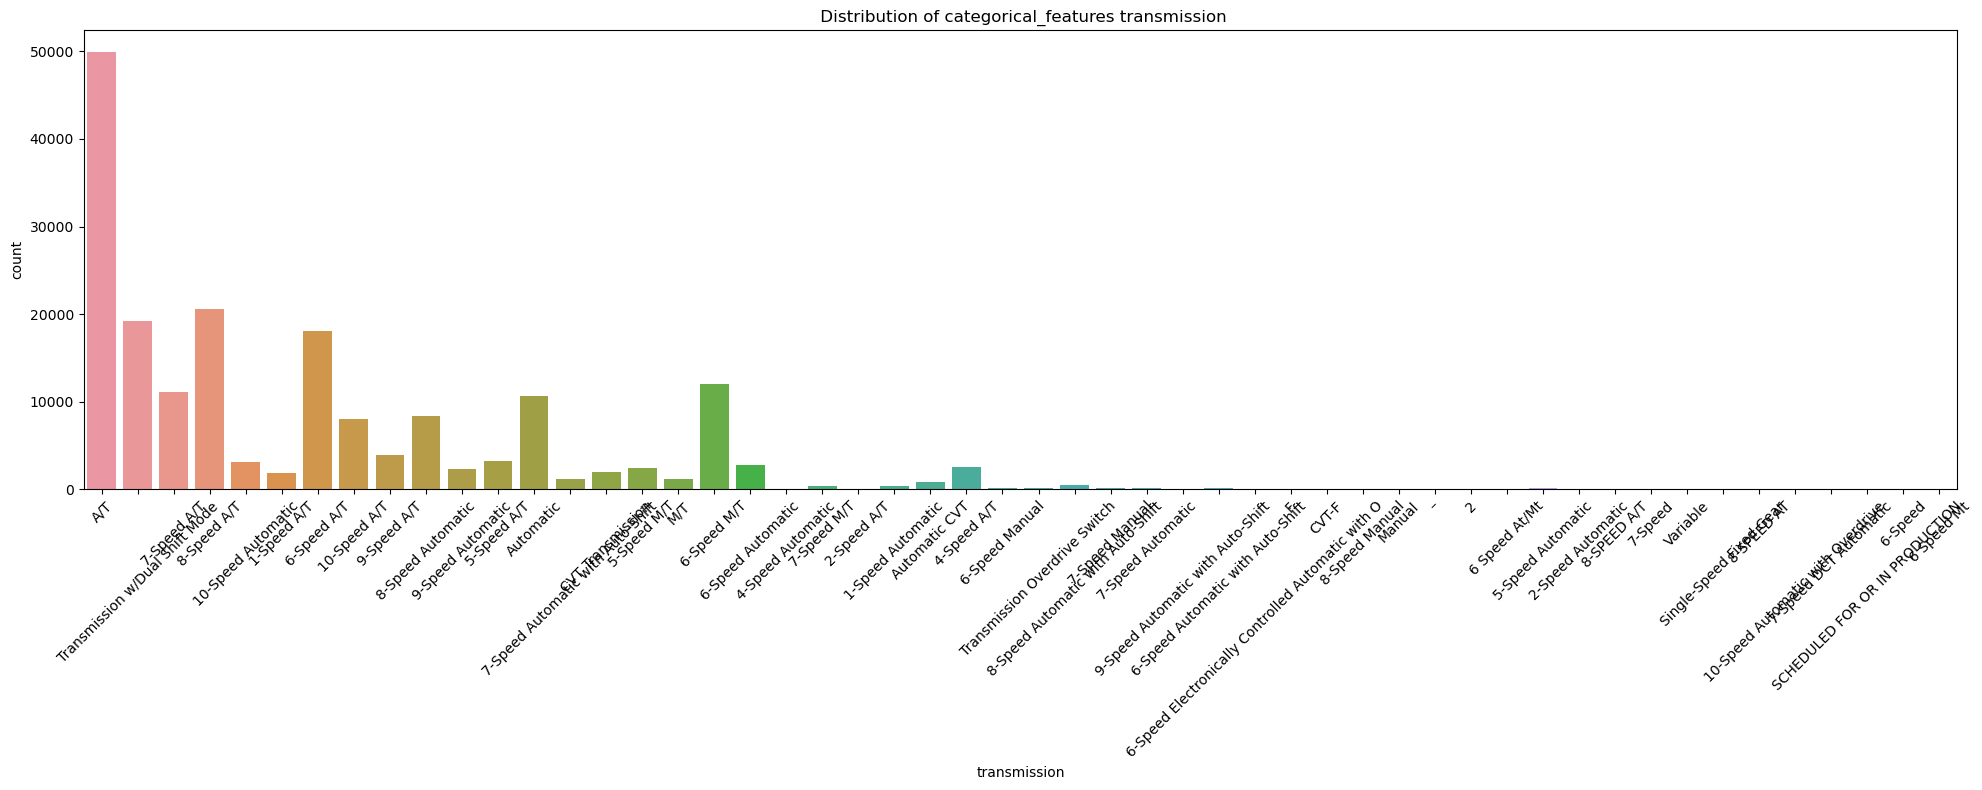

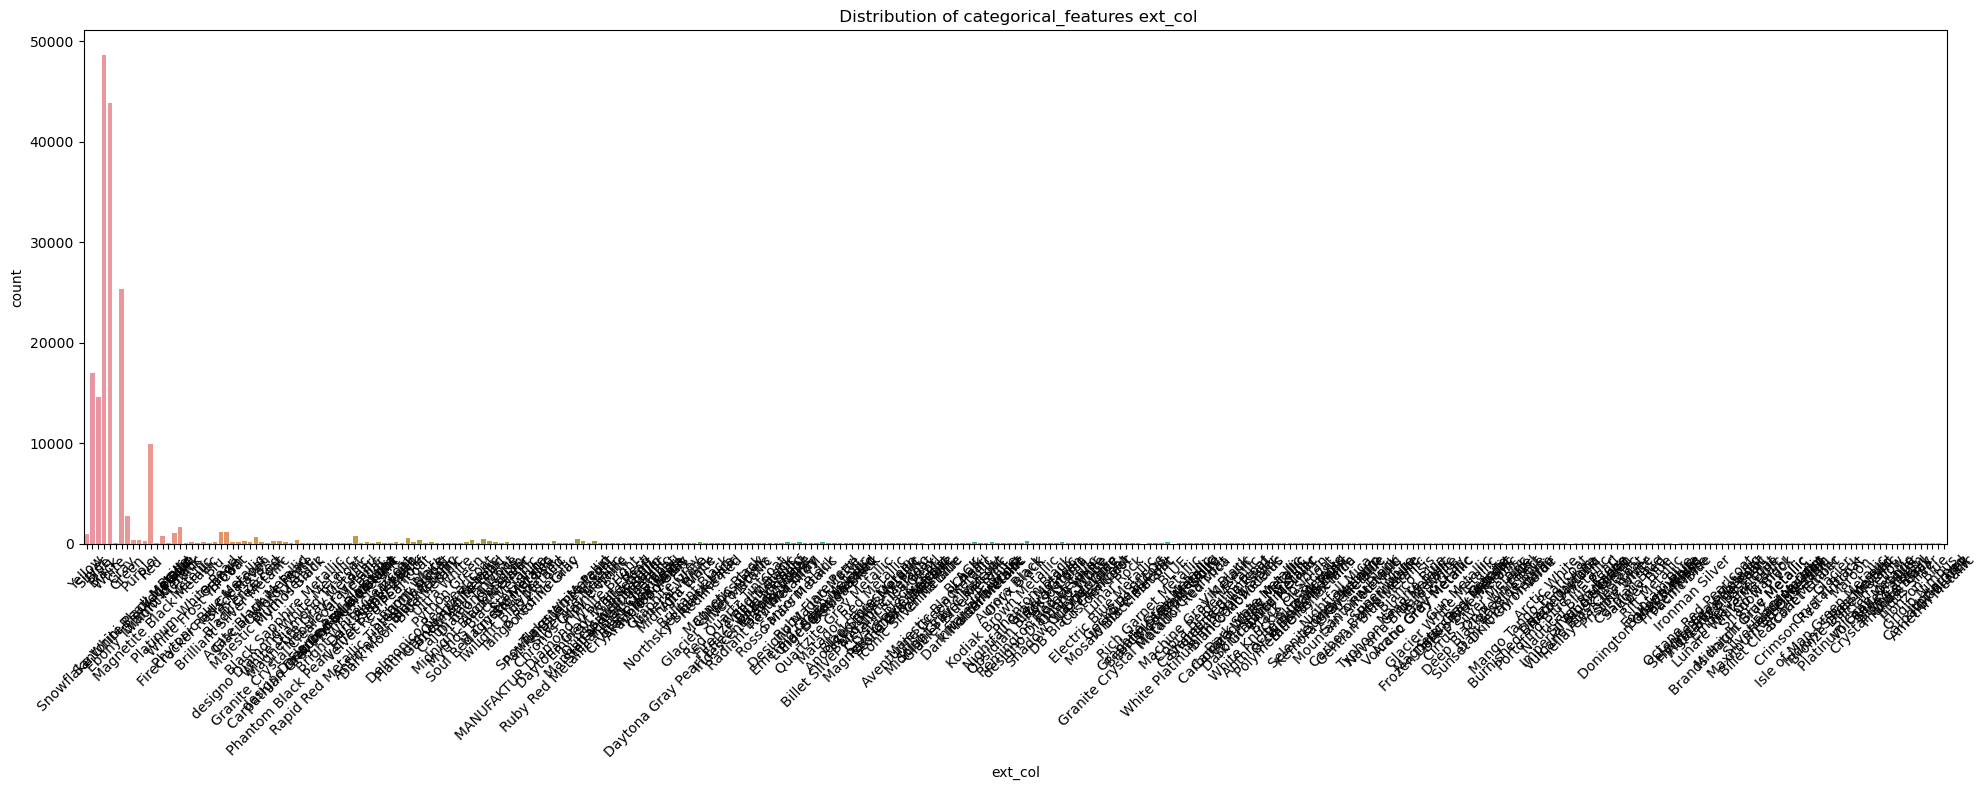

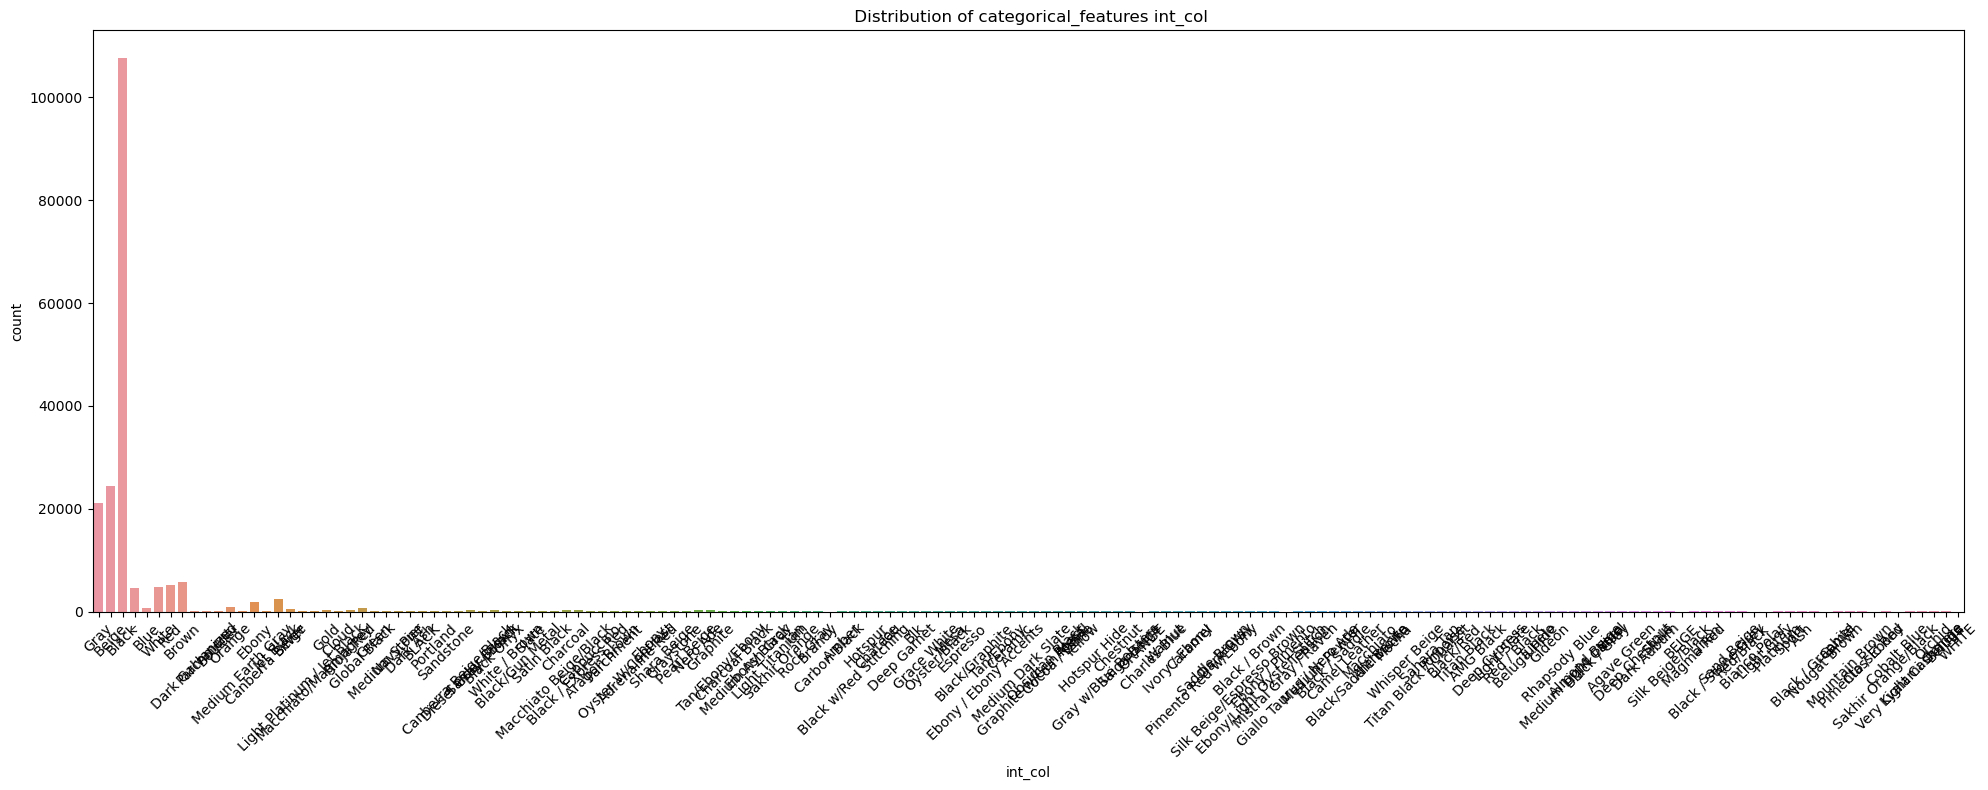

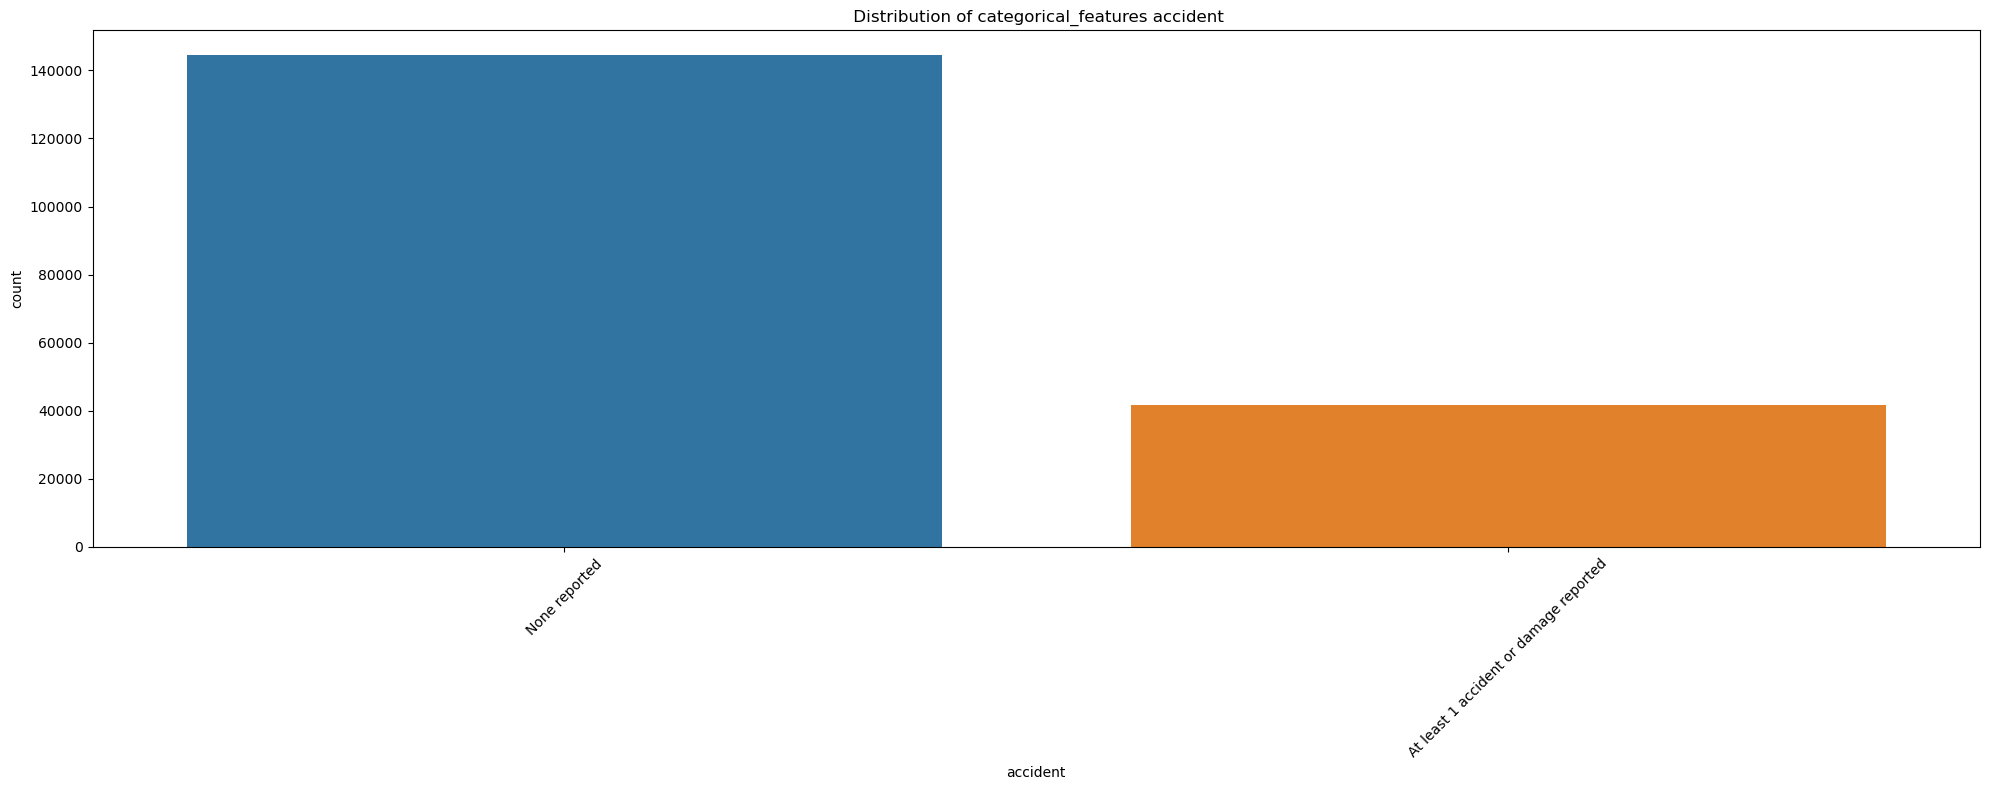

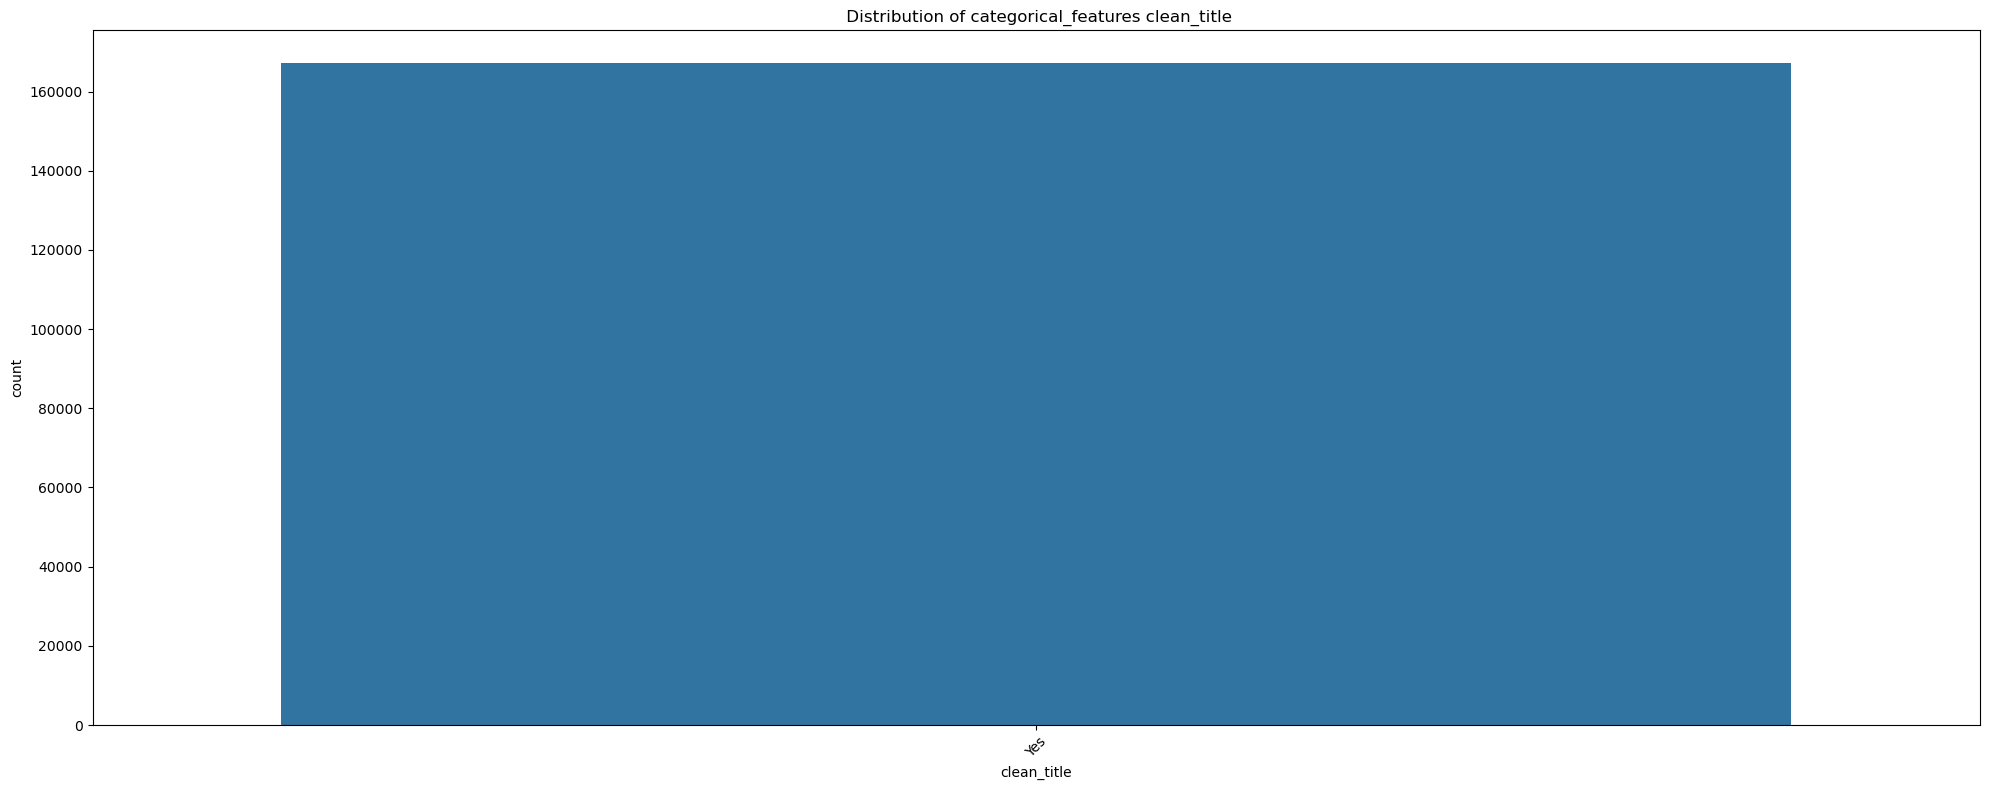

In [17]:
for col in cat_cols:
    plt.figure(figsize=(20, 8))
    sns.countplot(x=col, data=train)
    plt.title(f' Distribution of categorical_features {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

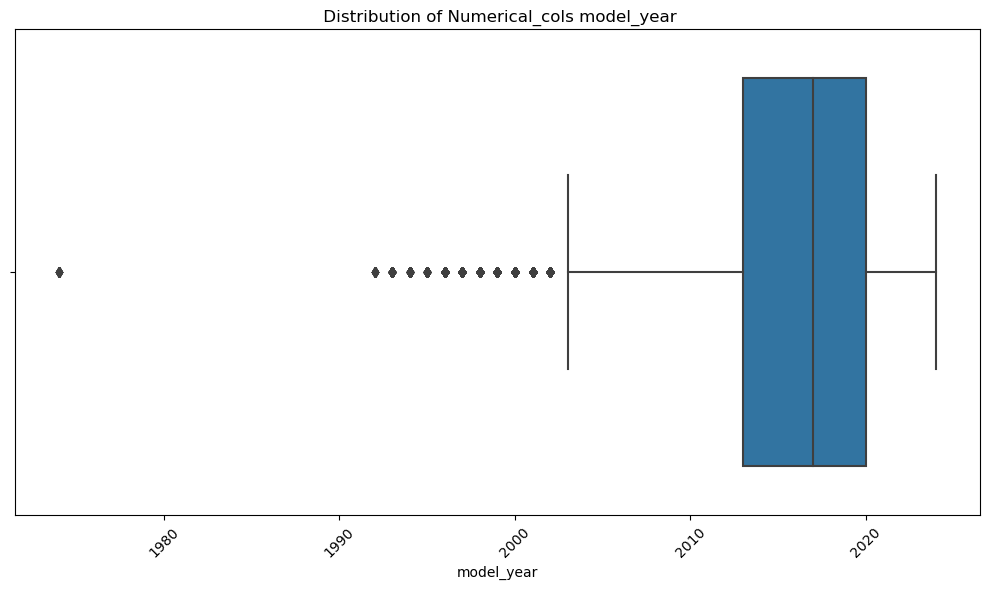

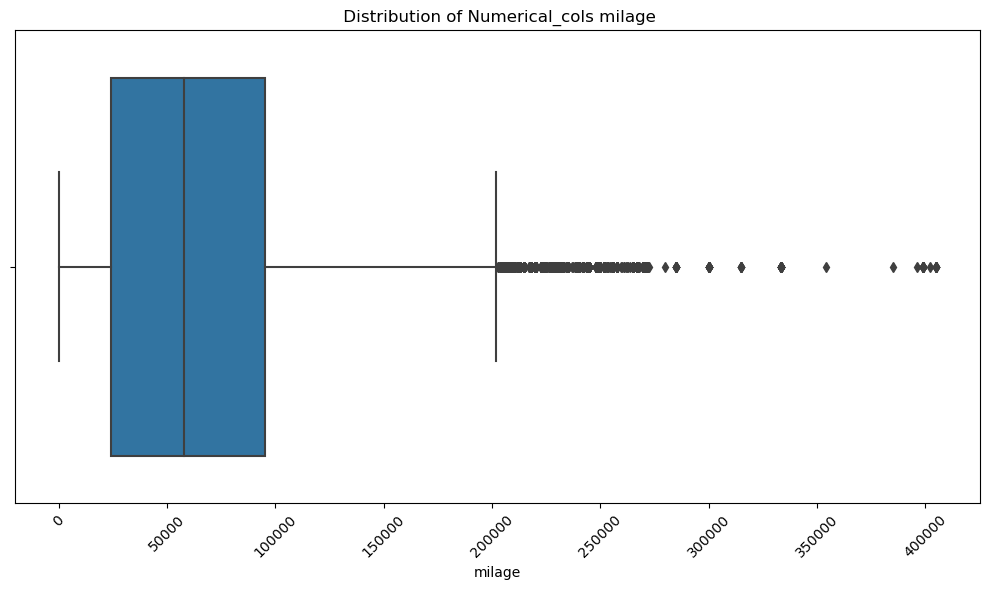

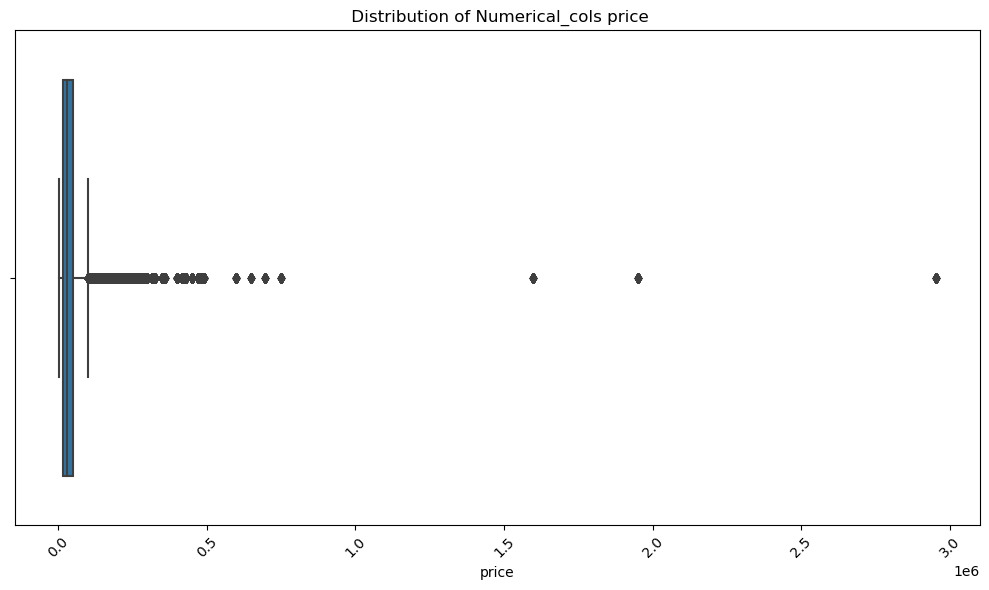

In [18]:
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, data=train)
    plt.title(f' Distribution of Numerical_cols {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [19]:
def extract_age_features(df):
    current_year = 2024

    df['Vehicle_Age'] = current_year - df['model_year']
    
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']
    df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    
    df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
 
#     df['milage_brand'] =  df.groupby('brand')['milage'].transform('mean')
    
    
    return df

In [20]:
def extract_engine_features(df):
    
    def extract_horsepower(engine):
        try:
            return float(engine.split('HP')[0])
        except:
            return None

    def extract_engine_size(engine):
        try:
            return float(engine.split(' ')[1].replace('L', ''))
        except:
            return None

    df['Horsepower'] = df['engine'].apply(extract_horsepower)
    df['Engine_Size'] = df['engine'].apply(extract_engine_size)
    df['Power_to_Weight_Ratio'] = df['Horsepower'] / df['Engine_Size']
    
    return df

In [21]:
def extract_other_features(df):
    
    luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    
    
    vintage_brands = ['Chevrolet', 'Ford', 'Buick', 'Pontiac', 'Saturn', 'Hummer', 
                      'Chrysler', 'Plymouth', 'Saab', 'Bugatti', 'Mercury']
    
    
    df['Is_Luxury_or_Vintage'] = df['brand'].apply(lambda x: 1 if x in luxury_brands or x in vintage_brands else 0)

    return df


In [22]:
%%time

train = extract_age_features(train)
test = extract_age_features(test)

train = extract_other_features(train)
test = extract_other_features(test)


CPU times: total: 172 ms
Wall time: 150 ms


# Model_year

In [23]:

train.drop(columns=['model_year','clean_title'], inplace=True)
test.drop(columns=['model_year','clean_title'], inplace=True)

In [24]:
train.head()

,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,Vehicle_Age,Mileage_per_Year,milage_with_age,Mileage_per_Year_with_age,Is_Luxury_or_Vintage
0,MINI,Cooper S Base,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200,17,12529.411765,118515.705906,6971.512112,0
1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999,22,6511.363636,118470.721529,5385.032797,0
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,13900,22,6215.045455,118470.721529,5385.032797,1
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,45000,7,2785.714286,67940.690480,9705.812926,0
4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,97500,3,2462.666667,29346.041378,9782.013793,1


In [25]:
def update(df):
    
    t = 100
    
    cat_c = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident',
             
            ]
    re_ = ['model','engine','transmission','ext_col','int_col']
    
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
    for col in cat_c:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
        
    return df

train  = update(train)
test   = update(test)

X = train.drop('price', axis=1)
y = train['price']

In [26]:
X.head()

,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,Vehicle_Age,Mileage_per_Year,milage_with_age,Mileage_per_Year_with_age,Is_Luxury_or_Vintage
0,MINI,Cooper S Base,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,17,12529.411765,118515.705906,6971.512112,0
1,Lincoln,noise,143250,Gasoline,noise,A/T,Silver,Beige,At least 1 accident or damage reported,22,6511.363636,118470.721529,5385.032797,0
2,Chevrolet,noise,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,22,6215.045455,118470.721529,5385.032797,1
3,Genesis,noise,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,7,2785.714286,67940.690480,9705.812926,0
4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,3,2462.666667,29346.041378,9782.013793,1


In [27]:
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold



callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=200)]

cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"cat_cols--------{cat_cols}")


def get_MAE_oof(df, target, lgb_params, cat_params=None, model_type='LGBM'):

    
    oof_predictions = np.zeros(len(df))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    rmse_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training fold {fold + 1}/{5} with {model_type}")

        X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

        if model_type == 'LGBM':
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                lgb_params,
                train_data,
                valid_sets=[train_data, val_data],
                valid_names=['train', 'valid'],
                callbacks=callbacks    
            )
        
        elif model_type == 'CAT':
            train_data = Pool(data=X_train, label=y_train , cat_features=cat_cols)
            val_data = Pool(data=X_val, label=y_val , cat_features=cat_cols )
            
            model = CatBoostRegressor(**cat_params)
            model.fit(train_data, eval_set=val_data, verbose=150, early_stopping_rounds=200)
        
        models.append(model)
        
        if model_type == 'LGBM':
            pred = model.predict(X_val, num_iteration=model.best_iteration)
        elif model_type == 'CAT':
            pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmse_scores.append(rmse)

        print(f'{model_type} Fold RMSE: {rmse}')
        
        oof_predictions[val_idx] = pred
        
    print(f'Mean RMSE: {np.mean(rmse_scores)}')
    return oof_predictions, models




lgb_params = {
    'objective': 'MAE',
    'n_estimators': 1000,
    'random_state': 42,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')
X['LGBM_MAE'] = oof_predictions_lgbm


LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MAE'] = LGBM_preds



lgb_params = {
    'objective': 'MSE',
    'n_estimators': 1000,
    'random_state': 42,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')

X['LGBM_MSE_diff'] = oof_predictions_lgbm - X['LGBM_MAE']


LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MSE_diff'] = LGBM_preds - test['LGBM_MAE']

cat_cols--------['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident']
Training fold 1/5 with LGBM
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 14
[LightGBM] [Info] Start training from score 30798.000000
Training until validation scores don't improve for 200 rounds
[300]	train's l1: 16431.4	valid's l1: 17116.7
[600]	train's l1: 16185.3	valid's l1: 17111.1
Early stopping, best iteration is:
[649]	train's l1: 16148.4	valid's

In [28]:

def objective_lgb(trial):   
    lgb_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
        'n_estimators': 1000,
        'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(lgb_params, 
                          train_data, 
                          valid_sets=[val_data], 
                          callbacks=callbacks
                         )

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

def objective_cat(trial):

    cat_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 5, 16),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),
        'iterations': 1000,
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'cat_features': cat_cols,
        'random_seed': 42,
        'task_type': 'GPU',
        'early_stopping_rounds': 200
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores_cat = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        train_pool = Pool(X_train, y_train, cat_features=cat_cols)
        val_pool = Pool(X_val, y_val, cat_features=cat_cols)
        
        model_cat = CatBoostRegressor(**cat_params)
        model_cat.fit(train_pool, eval_set=val_pool, verbose=300)
        
        y_pred_cat = model_cat.predict(X_val)
        rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
        rmse_scores_cat.append(rmse_cat)
    
    return np.mean(rmse_scores_cat)

if USE_OPTUNA==True:
    study_lgb = optuna.create_study(direction='minimize')
    study_lgb.optimize(objective_lgb, n_trials=20)

    print("Best LGBM Parameters: ", study_lgb.best_params)
    print("Best LGBM RMSE: ", study_lgb.best_value)

    study_cat = optuna.create_study(direction='minimize')
    study_cat.optimize(objective_cat, n_trials=2)

    print("Best CatBoost Parameters: ", study_cat.best_params)
    print("Best CatBoost RMSE: ", study_cat.best_value)


In [29]:
lgb_params_1 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'extra_tree' : True,
    'verbose' : -1
}

lgb_params_2 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose' : -1
}

cat_params={
    'learning_rate':0.042,
    'iterations':1000,
    'depth':10,
    'random_strength' : 10,
    'cat_features':cat_cols,
    'l2_leaf_reg':0.3,
    'random_seed':42,
    'early_stopping_rounds': 200,
    'task_type':'CPU',
}



kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
rmse_scores_cat = []
LGBM_model=[]
CAT_model =[]

callbacks = [log_evaluation(period=150), early_stopping(stopping_rounds=200)]

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model_1 = lgb.train(lgb_params_1,
                      train_data,
                      valid_sets=[train_data, val_data],
                      valid_names=['train', 'valid'],
                      callbacks=callbacks        
                      )
    model_2 = lgb.train(lgb_params_2,
                  train_data,
                  valid_sets=[train_data, val_data],
                  valid_names=['train', 'valid'],
                  callbacks=callbacks        
                  )
    
    LGBM_model.append(model_1)
    LGBM_model.append(model_2)

    y_pred = model_1.predict(X_val) * 0.5 + model_2.predict(X_val) * 0.5
    

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    
    print(f'LGBM Fold RMSE: {rmse}')
    
    
    model_cat = CatBoostRegressor(**cat_params)
    

    train_pool = Pool(X_train, y_train ,cat_features=cat_cols)
    val_pool = Pool(X_val, y_val , cat_features=cat_cols)
    model_cat.fit(train_pool, eval_set=val_pool, verbose=300)
    
    CAT_model.append(model_cat)
    y_pred_cat = model_cat.predict(X_val)
    rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
    rmse_scores_cat.append(rmse_cat)
    
    print(f'CAT Fold RMSE: {rmse_cat}')


print(f'Mean LGBM RMSE: {np.mean(rmse_scores)}')
print(f'Mean CAT RMSE: {np.mean(rmse_scores_cat)}')

Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.33908e+09	valid's l2: 4.63106e+09
[300]	train's l2: 5.19024e+09	valid's l2: 4.61002e+09
[450]	train's l2: 5.0667e+09	valid's l2: 4.61474e+09
Early stopping, best iteration is:
[274]	train's l2: 5.21251e+09	valid's l2: 4.60981e+09
Training until validation scores don't improve for 200 rounds
[150]	train's l2: 4.68637e+09	valid's l2: 4.62331e+09
[300]	train's l2: 4.12221e+09	valid's l2: 4.61943e+09
Early stopping, best iteration is:
[197]	train's l2: 4.49095e+09	valid's l2: 4.6169e+09
LGBM Fold RMSE: 67849.04084837243
0:	learn: 79517.1574278	test: 74206.6573605	best: 74206.6573605 (0)	total: 325ms	remaining: 5m 24s
300:	learn: 71112.6498682	test: 67952.9853276	best: 67944.5865085 (287)	total: 1m 25s	remaining: 3m 18s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 67873.75797
bestIteration = 367

Shrink model to first 368 iterations.
CAT Fold RMSE: 67873.75797315121
Training until validat

In [30]:
LGBM_preds = np.zeros(len(test))
for model in LGBM_model:
    LGBM_preds += model.predict(test) / len(LGBM_model)

In [31]:
CAT_preds = np.zeros(len(test))
for model in CAT_model:
    CAT_preds += model.predict(test) / len(CAT_model)

In [37]:
feature_names = X.columns


lgb_importances = np.zeros(len(feature_names))

for model in LGBM_model:
    lgb_importances += model.feature_importance(importance_type='split') / len(LGBM_model)

lgb_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importances})
lgb_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)


print(lgb_feature_importance)


                      Feature  Importance
10           Mileage_per_Year      2785.6
5                transmission      2642.1
0                       brand      2473.6
15              LGBM_MSE_diff      2239.6
2                      milage      1987.0
4                      engine      1823.8
14                   LGBM_MAE      1759.6
1                       model      1731.6
6                     ext_col      1691.8
7                     int_col      1401.0
9                 Vehicle_Age      1331.7
8                    accident      1022.7
11            milage_with_age       984.5
12  Mileage_per_Year_with_age       968.0
13       Is_Luxury_or_Vintage       856.5
3                   fuel_type       837.8


In [38]:
feature_names = X.columns
cat_importances = np.zeros(len(feature_names))

for model in CAT_model:
 
    cat_importances += model.get_feature_importance(type='FeatureImportance') / len(CAT_model)

cat_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importances})
cat_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)


print(cat_feature_importance)

                      Feature  Importance
14                   LGBM_MAE   20.264583
0                       brand    9.409424
6                     ext_col    7.263379
15              LGBM_MSE_diff    7.096730
5                transmission    7.057703
2                      milage    6.920755
4                      engine    6.897913
7                     int_col    6.609597
3                   fuel_type    4.961894
1                       model    4.915296
8                    accident    4.516570
10           Mileage_per_Year    4.416354
11            milage_with_age    3.845779
9                 Vehicle_Age    2.654241
12  Mileage_per_Year_with_age    1.755901
13       Is_Luxury_or_Vintage    1.413882


In [36]:
# Blend LGBM and CatBoost predictions
test_preds = LGBM_preds * 0.7 + CAT_preds * 0.3

# Assign directly to submission
sample_sub['price'] = test_preds

# Save submission
sample_sub.to_csv("submission_2nd_5th_place.csv", index=False)
print(sample_sub.head())


       id         price
0  188533  19020.291195
1  188534  76331.136199
2  188535  57168.482114
3  188536  30465.332382
4  188537  30634.818228


(array([6.3450e+04, 3.9196e+04, 1.6097e+04, 4.7280e+03, 1.3640e+03,
        4.8300e+02, 2.3700e+02, 1.2000e+02, 1.3000e+01, 2.0000e+00]),
 array([  8113.12890146,  37351.22659273,  66589.324284  ,  95827.42197527,
        125065.51966654, 154303.61735781, 183541.71504909, 212779.81274036,
        242017.91043163, 271256.0081229 , 300494.10581417]),
 <BarContainer object of 10 artists>)

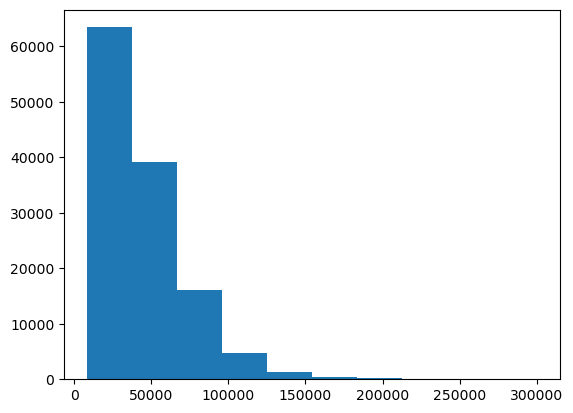

In [35]:
plt.hist(sample_sub['price'])